# Dimensionality Reduction and Clustering

In this notebook, we will look at a few methods of dimensionality reduction and clustering, inluding PCA, t-SNE, k-means clustering, and hierarchical clustering. We will use these methods on the MNIST dataset, a collection of 28by28 pixel images depicting handwritten numbers 0-9. Dimensionality reduction will be performed using PCA, with comparisons of different degrees of reduction as well as of how much visual information is lost in the compression. Clustering will be performed by using the remaining methods, often in tandem with PCA to reduce computing time.

##### Setting up and importing data

In [1]:
# Import our tools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import sklearn

# Fix some settings
sns.set(style = 'ticks', palette='Set2')
%matplotlib inline
plt.style.use('seaborn')
pd.set_option('display.max_columns', 50)

In [2]:
# Import our dataset
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata("MNIST original")
X = mnist.data / 255.0
y = mnist.target

Now we can get a feel for our data. We'll check on the size of the datasets and then visualize a few of the images.

In [3]:
# Make sure our arrays are the right size
print(X.shape, y.shape)

(70000, 784) (70000,)


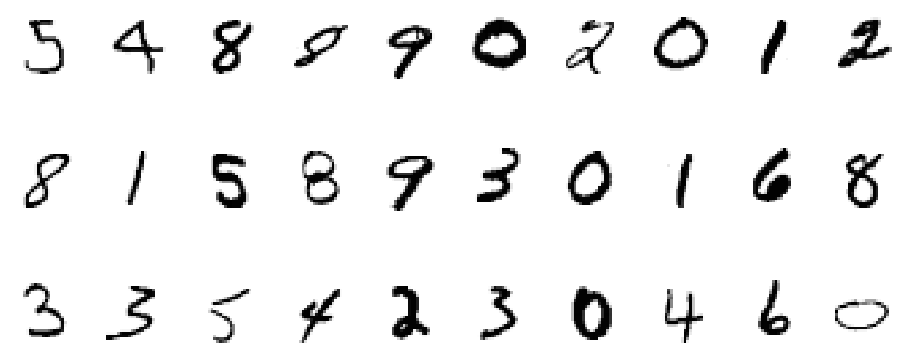

In [4]:
# Create a dataset with the numbers in a random order
rndm = np.random.permutation(X.shape[0])

# Create a dataframe
features = ['pixel' + str(i) for i in range(X.shape[1])]
dfX = pd.DataFrame(X, columns = features)

# Display the first 30 images
fig = plt.figure( figsize=(16,7) )
for i in range(0,30):
    ax = fig.add_subplot(3,10,i+1)
    ax.grid(False)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.matshow(dfX.loc[rndm[i]].values.reshape((28,28)).astype(float), cmap = 'Greys')
plt.show()

## Dimensionality Reduction with PCA

In [5]:
# Import tools for dimensionality reduction and clustering
from sklearn.datasets import make_regression
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

### PCA

First we need to decide how many components to include. We can do this by one of two methods: 1) choosing a threshold percent of variance (e.g. 80%) that we want explained by our components, or 2) looking at how the amount of explained-variance increase as we increase the number of components and trying to find the "elbow" of the curve. We use the second method here, borrowing from tfolkman's code in "Lecture_12_Dimensionality Reduction."

Choosing the number of components based off looking for an elbow in the curve is somewhat subjective, but it looks to me like 25 components is a pretty good choice. Later we'll compare how much information is lost compared to using 10 or 100 components.

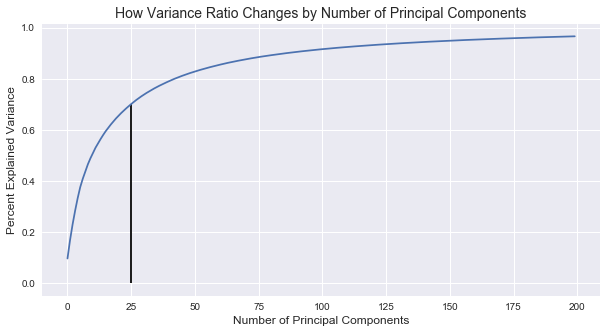

In [6]:
# Create curve to find the "elbow"
pca = PCA(n_components=200)
X_pca = pca.fit_transform(X)
cum_ratio = np.cumsum(pca.explained_variance_ratio_)
f, ax = plt.subplots(figsize = (10,5))
ax.set_title("How Variance Ratio Changes by Number of Principal Components", fontsize = 14)
plt.ylabel("Percent Explained Variance", fontsize = 12)
plt.xlabel("Number of Principal Components", fontsize = 12)
plt.plot(range(len(cum_ratio)), cum_ratio)
plt.vlines(ymin=0,ymax=cum_ratio[25],x=25)
plt.show()

Next we perform PCA with 25 components and then plot the first two principle components against each other.

In [7]:
# PCA with 25 components
pca = PCA(n_components=25)
Xdim25 = pca.fit_transform(X)
Xdim25I = pca.inverse_transform(Xdim25)

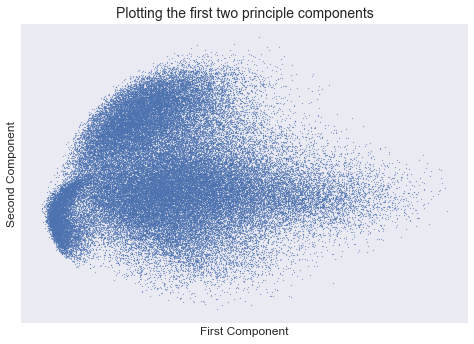

In [8]:
plt.title("Plotting the first two principle components", fontsize=14)
plt.ylabel("Second Component", fontsize = 12)
plt.xlabel("First Component", fontsize = 12)
plt.xticks([])
plt.yticks([])
plt.scatter(Xdim25[:,0], Xdim25[:,1], alpha=.5, s=1)
plt.show()

There are a couple things we can point out in this image. First, notice that the first component has more variance than the second. This is what we would expect since the first component in PCA is the linear combination that gives the most variance. The second thing we can highlight is that there doesn't seem to be any trend or correlation between the two components. This is also what we might expect since the second component will mostly capture variation that the first component missed.

##### PCA: What and when?
What is PCA doing? As we mentioned, it's a method for finding the linear combinations of features that have the most variance, and ordering them from most variance explained to least. PCA is useful as a rudimentary way of compressing data, although a serious drawback is that there is always some variance lost, that is, we lose some explanatory power. In this case, that loss of variation makes the images look blurrier. Another way of using PCA is how we use it later in this notebook: it gives us a tool for creating smaller datasets that are very similar to our large dataset. This can drastically decrease run-time, since higher dimensionality can quickly make calculations take much longer. Once again, however, there is always the cost of losing some explained variation.

#### Visualizing Effects of PCA

Now we're ready to look at what our dimensionality reduction looks like in practice. We'll compare the original image of a 3 to the images that are generated after performing PCA with 10, 25, and 100 components.

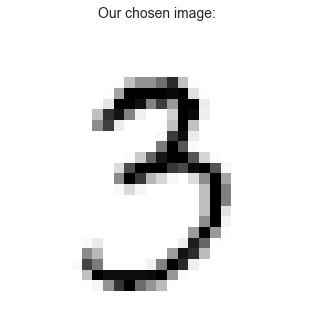

In [9]:
# We display the original image
plt.imshow(X[20000].reshape((28,28)), cmap='Greys')
plt.title("Our chosen image:", fontsize=14)
plt.xticks([])
plt.yticks([])
plt.show()

In [10]:
# PCA with 10 components
pca = PCA(n_components=10)
Xdim10 = pca.fit_transform(X)
Xdim10I = pca.inverse_transform(Xdim10)

# PCA with 100 components
pca = PCA(n_components=100)
Xdim100 = pca.fit_transform(X)
Xdim100I = pca.inverse_transform(Xdim100)

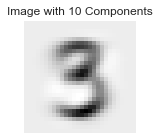

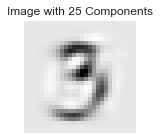

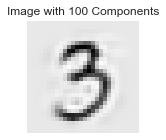

In [11]:
# Plot image with 10 components
fig = plt.figure( figsize=(16,7) )
ax = fig.add_subplot(3,1,1)
ax.grid(False)
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.title("Image with 10 Components")
plt.imshow(Xdim10I[20000].reshape((28,28)), cmap='Greys')
    
# Plot image with 25 components
fig = plt.figure( figsize=(16,7) )
ax = fig.add_subplot(3,1,2)
ax.grid(False)
ax.set_yticklabels([])
ax.set_xticklabels([])    
plt.title("Image with 25 Components")
plt.imshow(Xdim25I[20000].reshape((28,28)), cmap='Greys')

# Plot image with 100 components
fig = plt.figure( figsize=(16,7) )
ax = fig.add_subplot(3,1,3)
ax.grid(False)
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.title("Image with 100 Components")
plt.imshow(Xdim100I[20000].reshape((28,28)), cmap='Greys')
plt.show()

Interestingly, even 10 components is enough to clearly see that the image is of a 3, at least in this case. Also, it appears 100 components is enough for the image to look about the same as it did before compression.

### t-SNE

t-SNE is a clever (and somehwat complicated) method for visualizing higher dimensional data in 2 dimensions, where it is much easier to see distances. The algorithm attempts to preserve relative distances as it moves the data from k-dimensional space to 2d. Because of the intensity of the computations involved, we use a random 10,000 row sample of our data. Also, to help it run faster we first perform PCA to reduce it's dimensionality to the first 25 principle components.

t-SNE contains several hyperparemeters. The most important of these include perplexity (sometimes referred to below as "perplex"), number of iterations (iter), and learning rate(LR). The default values for number of iterations and LR in sklearn are 1000 and 200 respectively. We first look at the output of t-SNE as we vary perplexity within the suggested range of 5-50 (we use 5, 15, and 45). We then look at how the number of iterations and the learning rate can affect the output when we use a perplexity of 45.

Conclusions:
1. It looks like a perplexity of 45 did the best job of separating our 10 clusters (digits).
2. Decreasing the number of iterations to its minimum drastically reduced its effectiveness in separating the clusters, although it also significantly decreased run time. Increasing the number of iterations to 2000 had a modest effect on the outcome, perhaps slightly improving performance, but I don't think it was worth the much longer run time.
3. The learning rate had somewhat of an effect, but it was not as drastic as the effects of the other hyperparameters. The default value of 200 seems to be the best value.

In [12]:
#Dimensionality reduction with 25 components (to make it run faster)
pca = PCA(n_components=20)
X_pca = pca.fit_transform(X)

# Randomly sample 10,000 observations
rows = np.arange(70000)
np.random.shuffle(rows)
n_select = 10000

# TSNE with perplexity 5
tsne5 = TSNE(n_components=2, verbose=1, perplexity=5, n_iter=1000, learning_rate=200)
tsne_results5 = tsne5.fit_transform(X_pca[rows[:n_select],:])

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.016s...
[t-SNE] Computed neighbors for 10000 samples in 3.436s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.801341
[t-SNE] KL divergence after 250 iterations with early exaggeration: 94.903351
[t-SNE] Error after 1000 iterations: 1.884367


In [13]:
df_tsne5 = pd.DataFrame(tsne_results5, columns=['comp1', 'comp2'])
df_tsne5['label'] = y[rows[:n_select]]

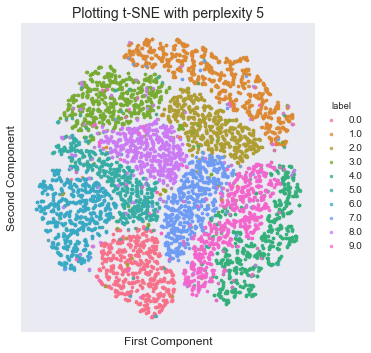

In [14]:
sns.lmplot(x='comp1', y='comp2', data=df_tsne5, hue='label', fit_reg=False, markers='.')
plt.title("Plotting t-SNE with perplexity 5", fontsize=14)
plt.ylabel("Second Component", fontsize = 12)
plt.xlabel("First Component", fontsize = 12)
plt.xticks([])
plt.yticks([])
plt.show()

Repeat for perplexity of 15 and 45

[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.030s...
[t-SNE] Computed neighbors for 10000 samples in 6.814s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.112417
[t-SNE] KL divergence after 250 iterations with early exaggeration: 89.274185
[t-SNE] Error after 1000 iterations: 1.838435


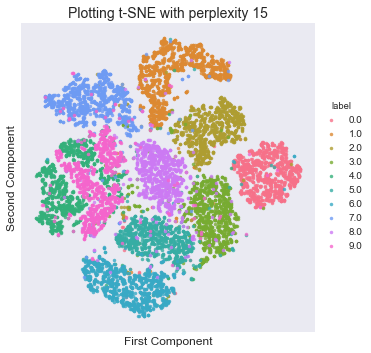

In [15]:
tsne15 = TSNE(n_components=2, verbose=1, perplexity=15, n_iter=1000, learning_rate=200)
tsne_results15 = tsne15.fit_transform(X_pca[rows[:n_select],:])

df_tsne15 = pd.DataFrame(tsne_results15, columns=['comp1', 'comp2'])
df_tsne15['label'] = y[rows[:n_select]]

sns.lmplot(x='comp1', y='comp2', data=df_tsne15, hue='label', fit_reg=False, markers='.')
plt.title("Plotting t-SNE with perplexity 15", fontsize=14)
plt.ylabel("Second Component", fontsize = 12)
plt.xlabel("First Component", fontsize = 12)
plt.xticks([])
plt.yticks([])
plt.show()

[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.032s...
[t-SNE] Computed neighbors for 10000 samples in 7.218s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.112417
[t-SNE] KL divergence after 250 iterations with early exaggeration: 90.288849
[t-SNE] Error after 1000 iterations: 1.845538


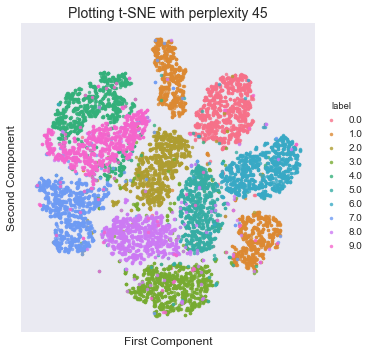

In [16]:
tsne45 = TSNE(n_components=2, verbose=1, perplexity=45, n_iter=1000, learning_rate=200)
tsne_results45 = tsne15.fit_transform(X_pca[rows[:n_select],:])

df_tsne45 = pd.DataFrame(tsne_results45, columns=['comp1', 'comp2'])
df_tsne45['label'] = y[rows[:n_select]]

sns.lmplot(x='comp1', y='comp2', data=df_tsne45, hue='label', fit_reg=False, markers='.')
plt.title("Plotting t-SNE with perplexity 45", fontsize=14)
plt.ylabel("Second Component", fontsize = 12)
plt.xlabel("First Component", fontsize = 12)
plt.xticks([])
plt.yticks([])
plt.show()

Now we look at changes in the number of iterations. We'll look at 250 (the minimum) and 2000 iterations to compare it to the 1000 we were doing before.

Notice the huge error when we use n_iter=250.

[t-SNE] Computing 136 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.033s...
[t-SNE] Computed neighbors for 10000 samples in 9.801s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.441415
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.889893
[t-SNE] Error after 251 iterations: 179769313486231570814527423731704356798070

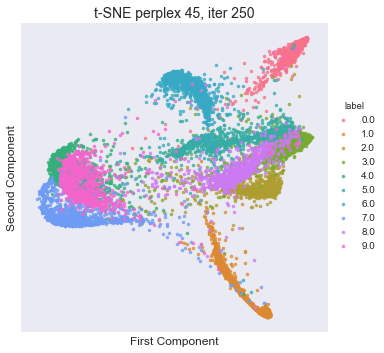

In [17]:
# We go from 1000 iterations to just 250 and see if that's enough to differentiate between the different numbers.
tsne45 = TSNE(n_components=2, verbose=1, perplexity=45, n_iter=250, learning_rate=200)
tsne_results45 = tsne45.fit_transform(X_pca[rows[:n_select],:])

df_tsne45 = pd.DataFrame(tsne_results45, columns=['comp1', 'comp2'])
df_tsne45['label'] = y[rows[:n_select]]

sns.lmplot(x='comp1', y='comp2', data=df_tsne45, hue='label', fit_reg=False, markers='.')
plt.title("t-SNE perplex 45, iter 250", fontsize=14)
plt.ylabel("Second Component", fontsize = 12)
plt.xlabel("First Component", fontsize = 12)
plt.xticks([])
plt.yticks([])
plt.show()

[t-SNE] Computing 136 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.016s...
[t-SNE] Computed neighbors for 10000 samples in 4.476s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.441415
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.850609
[t-SNE] Error after 2000 iterations: 1.623948


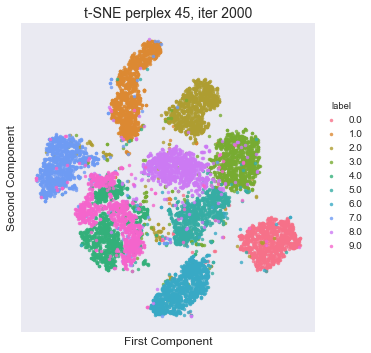

In [19]:
# And now up to 2000 iterations to see if it improves things over 1000 iterations.
tsne45 = TSNE(n_components=2, verbose=1, perplexity=45, n_iter=2000, learning_rate=200)
tsne_results45 = tsne45.fit_transform(X_pca[rows[:n_select],:])

df_tsne45 = pd.DataFrame(tsne_results45, columns=['comp1', 'comp2'])
df_tsne45['label'] = y[rows[:n_select]]

sns.lmplot(x='comp1', y='comp2', data=df_tsne45, hue='label', fit_reg=False, markers='.')
plt.title("t-SNE perplex 45, iter 2000", fontsize=14)
plt.ylabel("Second Component", fontsize = 12)
plt.xlabel("First Component", fontsize = 12)
plt.xticks([])
plt.yticks([])
plt.show()

Now on to learning rate.

[t-SNE] Computing 136 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.020s...
[t-SNE] Computed neighbors for 10000 samples in 4.524s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.441415
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.940643
[t-SNE] Error after 1000 iterations: 1.872920


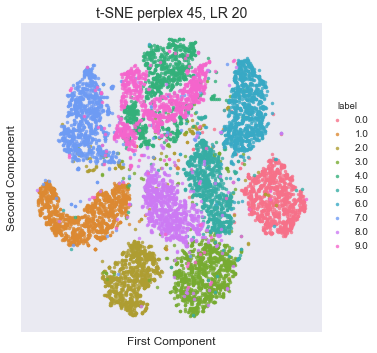

In [20]:
# Decrease learning rate to 20 (close to the minimum)
tsne45 = TSNE(n_components=2, verbose=1, perplexity=45, n_iter=1000, learning_rate=20)
tsne_results45 = tsne45.fit_transform(X_pca[rows[:n_select],:])

df_tsne45 = pd.DataFrame(tsne_results45, columns=['comp1', 'comp2'])
df_tsne45['label'] = y[rows[:n_select]]

sns.lmplot(x='comp1', y='comp2', data=df_tsne45, hue='label', fit_reg=False, markers='.')
plt.title("t-SNE perplex 45, LR 20", fontsize=14)
plt.ylabel("Second Component", fontsize = 12)
plt.xlabel("First Component", fontsize = 12)
plt.xticks([])
plt.yticks([])
plt.show()

[t-SNE] Computing 136 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.016s...
[t-SNE] Computed neighbors for 10000 samples in 4.370s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.441415
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.908073
[t-SNE] Error after 1000 iterations: 1.635963


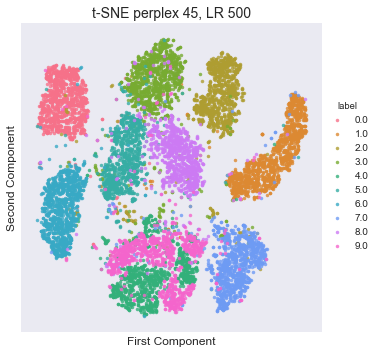

In [21]:
# Increase learning rate to 500
tsne45 = TSNE(n_components=2, verbose=1, perplexity=45, n_iter=1000, learning_rate=500)
tsne_results45 = tsne45.fit_transform(X_pca[rows[:n_select],:])

df_tsne45 = pd.DataFrame(tsne_results45, columns=['comp1', 'comp2'])
df_tsne45['label'] = y[rows[:n_select]]

sns.lmplot(x='comp1', y='comp2', data=df_tsne45, hue='label', fit_reg=False, markers='.')
plt.title("t-SNE perplex 45, LR 500", fontsize=14)
plt.ylabel("Second Component", fontsize = 12)
plt.xlabel("First Component", fontsize = 12)
plt.xticks([])
plt.yticks([])
plt.show()

## Clustering

### K-Means Clustering

Now we're ready for k-means clustering. k-means is a form of unsupervised learning: we simply tell the algorithm how many clusters we want it to find, and it tries to find the best 10 clusters. We'll compare the clusters that k-means finds to those in our best t-SNE plot.

In [22]:
# Silhouette_score is a method for evaluating our clustering
from sklearn.metrics import silhouette_score

We use 10 clusters since we know there are 10 digits. If we didn't know how many clusters we needed, then we could use an "elbow" method to choose like we did above for PCA. We train our algorithm on the same random subsample of 10000 observations that we used earlier for t-SNE for the same reasons: it takes too long to fun on the whole sample of 70000 images. In fact, my computer runs into memory problems if I perform it on the whole dataset.

In [23]:
# Tell the algorithm to find 10 clusters 
kmeans = KMeans(n_clusters=10)
kmeans.fit(X_pca[rows[:n_select],:])
sk_clusters = kmeans.predict(X_pca[rows[:n_select],:])
labels = kmeans.labels_

Now we evaluate the clustering based on the silhouette score. This score ranges from -1 to 1, with 1 being the best. It measures how well the algorithm is able to keep clusters tight and far away from each other. This could be one way of evaluating how many clusters to include.

Scoring: We get a score of about .06. That doesn't sound fantastic, but this isn't a trivial dataset to separate.

In [25]:
silhouette_score(X_pca[rows[:n_select],:], labels, metric='euclidean')

0.12869055338239366

Rescaling data: Note that because all of our features are on the same scale (from 0 to 255), we do not need to rescale them.

Now we'll compare the k-means clustering to the "true" clustering as seen in the t-SNE rendering.

As we can see below, k-means does a decent but imperfect job of clustering by digit.

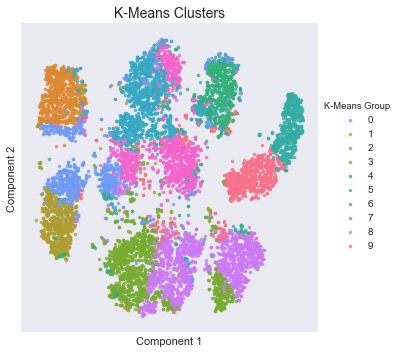

In [29]:
# K-Means Clusters
df_tsne45 = pd.DataFrame(tsne_results45, columns=['Component 1', 'Component 2'])
df_tsne45['K-Means Group'] = sk_clusters
sns.lmplot(x='Component 1', y='Component 2', data=df_tsne45, hue='K-Means Group', fit_reg=False, markers = ".")
ax = plt.gca()
ax.set_title("K-Means Clusters", fontsize=14)
plt.xticks([])
plt.yticks([])
plt.show()

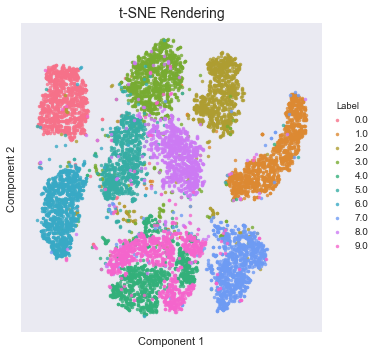

In [31]:
# t-TSNE Clusters
df_tsne45 = pd.DataFrame(tsne_results45, columns=['Component 1', 'Component 2'])
df_tsne45['Label'] = y[rows[:n_select]]
sns.lmplot(x='Component 1', y='Component 2', data=df_tsne45, hue='Label', fit_reg=False, markers = ".")
ax = plt.gca()
ax.set_title("t-SNE Rendering", fontsize=14)
plt.xticks([])
plt.yticks([])
plt.show()

We check the robustness of k-means by using our model to predict on a new subsample of 10,000 observations.

In [38]:
# New subsample
Xdf = pd.DataFrame(X_pca)
Xsample = Xdf.sample(n = 10000)

In [39]:
# t-SNE on new sample
tsne45 = TSNE(n_components=2, verbose=1, perplexity=45, n_iter=1000, learning_rate=200)
tsne_results45 = tsne15.fit_transform(Xsample)

df_tsne45 = pd.DataFrame(tsne_results45, columns=['comp1', 'comp2'])

[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.016s...
[t-SNE] Computed neighbors for 10000 samples in 3.564s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.148685
[t-SNE] KL divergence after 250 iterations with early exaggeration: 89.376732
[t-SNE] Error after 1000 iterations: 1.850867


In [40]:
# Predict on new subsample with old model
sk_clusters = kmeans.predict(Xsample)

We can see that k-means did about the same this time. This suggests that it's rather robust to the sample it receives.

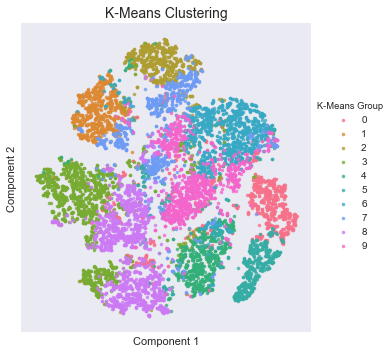

In [44]:
# Graph clustering
df_tsne45 = pd.DataFrame(tsne_results45, columns=['Component 1', 'Component 2'])
df_tsne45['K-Means Group'] = sk_clusters
sns.lmplot(x='Component 1', y='Component 2', data=df_tsne45, hue='K-Means Group', fit_reg=False, markers = ".")
ax = plt.gca()
ax.set_title("K-Means Clustering", fontsize=14)
plt.xticks([])
plt.yticks([])
plt.show()

### Hierarchical Clustering

Now we perform hierarchical clustering with several different linkage methods.

In [42]:
# Take a new subsample of the data. We only use 1000 observations to decrease run time.
Xsample = Xdf.sample(n = 1000)

We start with complete linkage. This method seems to suggest that around 30 clusters would be warranted. That may be true given how different people's handwriting can be, but that's not exactly what we would want. This is a caution to us when we want to trust what the algorithm gives us: it might not be what we were hoping for.

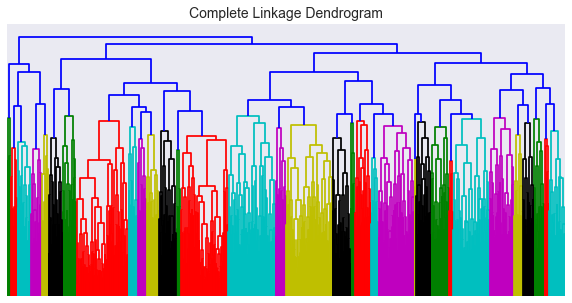

In [45]:
Z = linkage(Xsample, 'complete')

plt.figure(figsize=(10, 5))
dn_c = dendrogram(Z)
plt.title("Complete Linkage Dendrogram", fontsize=14)
plt.xticks([])
plt.yticks([])
plt.show()

Next we'll try the single linkage method. I'm not exactly sure what this shows, but I think it means 2 clusters might be best. This is sort of the other extreme from complete linkage.

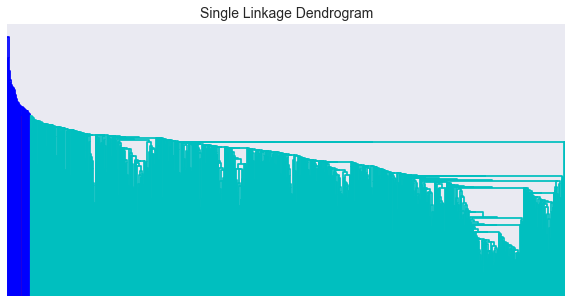

In [46]:
Z = linkage(Xsample, 'single')

plt.figure(figsize=(10, 5))
dn_c = dendrogram(Z)
plt.title("Single Linkage Dendrogram", fontsize=14)
plt.xticks([])
plt.yticks([])
plt.show()

Now we try ward linkage. This gives us something closer to what we might expect. Although there are only 5 colors displayed, looking at the dendrogram suggests that it would have been conceivable to find 10 clusters, although that might be because that's what I'm looking for.

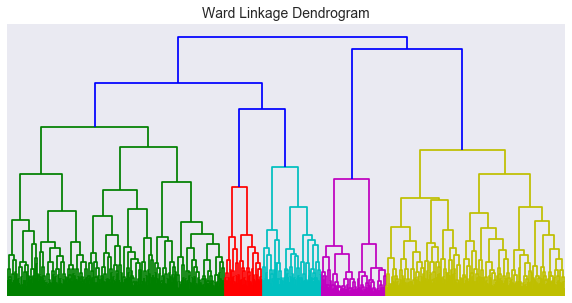

In [47]:
Z = linkage(Xsample, 'ward')

plt.figure(figsize=(10, 5))
dn_c = dendrogram(Z)
plt.title("Ward Linkage Dendrogram", fontsize=14)
plt.xticks([])
plt.yticks([])
plt.show()

From these dendrograms we can conclude that the linkage method greatly affects the outcome of the clustering.

### Conclusion:

We've learned that it's very important to have at least a basic understanding of what an algorithm is doing in order to use it well. The methods used in unsupervised learning can greatly affect the outcomes.